# Reinforcement Learning ep.2: Deep Q-Learning

<a target="_blank" href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab-16.RL_DeepQLearning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

*Goal: use Deep Q-Learning to play CartPole*

## Introduction to Cartpole

A pole is attached by an un-actuated joint to a cart, which moves along a 1-dim frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.


#### Action space
Breakout has the action space `Discrete(2)` with the table below lists the meaning of each action's meanings. 

- 1: Left
- 2: Right


#### Observations
By default, the environment returns the RGB image that is displayed to human players as an observation.

#### Rewards
In this task, rewards are +1 for every incremental timestep. This means better performing scenarios will run for longer duration, accumulating larger return.

#### Episode termination
* Pole Angle is more than 12 degrees
* Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
* Episode length is greater than 500, or another value set by the variable *env.\_max\_episode\_steps*

#### State space

At each game frame, the game engine provides information of the state. This state is then used to compute the features the agent will use. 

As starting state, all observations are assigned a uniformly random value in $(-0.05, 0.05)$.

The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state `(cart position, cart velocity, pole position, pole velocity)`. We take these 4 inputs without any scaling and pass them through a small fully-connected network with 2 outputs, one for each action. 


## Implementation
First, let's install the version of Gymnasium containing this environment.


In [ ]:
%%capture
!pip install "gymnasium[classic_control]"

In [ ]:
import gymnasium as gym

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython import display
from IPython.display import clear_output

import random
import math
from time import sleep
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The environment is the following:

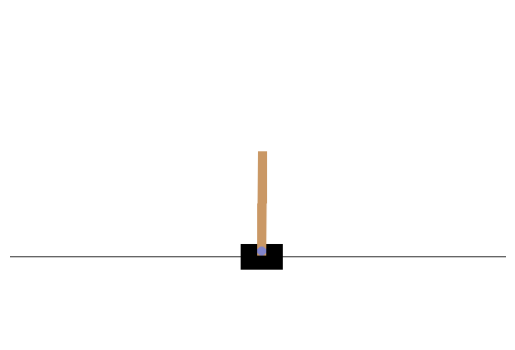

In [ ]:
env = gym.make('CartPole-v1', render_mode='rgb_array').env

env.reset()
img = env.render()
plt.axis('off')
plt.imshow(img)

We can see the size of the State space and of the Action space:

In [ ]:
print("Action Space: {}".format(env.action_space))
print()

print("State space: ", env.observation_space)
print()

low_bounds, high_bounds = (env.observation_space.low, env.observation_space.high)
print("1st element:\tPosition of the cart along the x-axis. Bounds: [%2.1f, %2.1f]" %(low_bounds[0], high_bounds[0]))
print("2nd element:\tCart velocity. Not bounded")
print("3rd element:\tPole angle. Bounds in radiants: [%2.1f, %2.1f]" %(low_bounds[2], high_bounds[2]))
print("4th element:\tPole velocity at its tip. Not bounded")

Action Space: Discrete(2)

State space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

1st element:	Position of the cart along the x-axis. Bounds: [-4.8, 4.8]
2nd element:	Cart velocity. Not bounded
3rd element:	Pole angle. Bounds in radiants: [-0.4, 0.4]
4th element:	Pole velocity at its tip. Not bounded


## Trying a naive strategy
One can define a naive strategy (i.e. the action to take by knowing the current state) based on the physical intuition of the problem. 

Remember that the best performance is having an episode cumulative reward of 500, because after 500 steps the environment automatcally resets (see episode termination above).
Having a smaller reward means that the episode has ended before 500 steps because (1) the angle of the pole has become too large, (2) the cart is outside the boundaries.

In [ ]:
def my_bad_policy(state):
    """
    If the pole angle is less than 0 (bent towards left) I apply a force towards left.
    """
    if state[2] < 0:
        return 0
    else:
        return 1 
    
def random_policy(state):
    return env.action_space.sample()

In [ ]:
def run(env, n_episodes, strategy):
    """
    Running the enviroment for a given number of episodes, according to a given strategy.
    It returns the average reward over all the episodes and the plotting frames for each episode.
    """
    done = False
    average_reward = 0   # cumulative reward averaged over all the episodes
    episodeframes = []   # list to save frames for each episode
    
    for _ in range(n_episodes): # cycle over all the episodes
        
        frames = []            # save frames
        state = env.reset()[0] # episode initialization
        ep_reward = 0          # reward for the episode
        
        while not done: 
            action = strategy(state) # Getting the action from the heuristic policy
            state, reward, done, truncated, info = env.step(action)
            ep_reward += reward

            frames.append(env.render())
            
            if truncated: # Check if the state is terminal
                break
                
        average_reward += ep_reward / float(n_episodes) 
        episodeframes.append(frames)
        
    return average_reward, episodeframes

Printing the average reward of the heuristic policy over some episodes:

In [ ]:
n_episodes = 100

badpolicy = run(env, n_episodes, my_bad_policy)
randompolicy = run(env, n_episodes, random_policy)

print(badpolicy[0])
print(randompolicy[0])

0.51
0.12


In [ ]:
def display_animation(frames):
    # turn off matplotlib plot in notebook
    plt.ioff()

    fps = 5   # Set frames per seconds
    dpi = 300  # Set dots per inch
    interval = 100  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    allframes = []
    for frame in frames:
        allframes.append(frame)

    # Fix frame size
    plt.figure(figsize=(allframes[0].shape[1] / dpi, allframes[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(allframes[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(allframes[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(allframes), interval=interval)

    video = anim.to_html5_video()
    html = display.HTML(video)
    return html

In [ ]:
html = display_animation(badpolicy[1][0])
display.display(html)

## Deep Q Learning

The comparison between Q-Learning and Deep Q-Learning is illustrated below.

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/04/Screenshot-2019-04-16-at-5.46.01-PM.png" alt= “” width="700">

Our aim will be to train a policy that tries to maximize the discounted, cumulative reward 
$$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$$
where $R_{t_0}$ is also known as the *reward*.  
The discount, $\gamma$, should be a constant between $0$ and $1$ that ensures the sum converges. A lower $\gamma$ makes rewards from the uncertain far future less important for our agent than the ones in the near future, of which it can be fairly confident 
about. It also encourages agents to collect reward closer in time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function $Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, and if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have access to $Q^*$. But, since **neural networks are universal function approximators**, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we'll use the fact that every $Q$ function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma \, Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the **temporal difference error**, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \, \max_a' Q(s', a))\end{align}

To minimize this error, we will use the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of $Q$ are very noisy. We calculate this over a batch of transitions, $B$, sampled from the replay memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}
Our model will be a feed forward  neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$ (where $s$ is the input to the network). In effect, the network is trying to predict the *expected return* of taking each action given the current input.


### Two networks

In deep Q-learning, there are two main components: the policy network (also known as the Q-network or online network) and the target network. These two networks serve different purposes and play specific roles in the learning process.

1. Policy Network:
   - The policy network is responsible for approximating the action-value function (Q-function) in Q-learning.
   - It takes the current state as input and outputs the estimated Q-values for all possible actions.
   - The policy network is updated during training by minimising the difference between the predicted Q-values and the target Q-values.
   - The updates to the policy network are driven by the temporal difference (TD) error.
   - The policy network is updated after each step or episode to continually improve its Q-value predictions.

2. Target Network:
   - The target network is a separate copy of the policy network that is used as a stable target for estimating the target Q-values during training.
   - The target network's parameters are not updated during the training process. Instead, they are updated periodically with a [soft update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the hyperparameter $\tau$. This is method of gradually updating the parameters of the target network from the parameters of the policy network by blending the parameters of the target network with the parameters of the policy network using a weighted average.
   - The purpose of the target network is to provide a more stable and reliable target for training the policy network.
   - By using a separate target network, it helps to mitigate the issue of the Q-value estimates being influenced by their own updates, which can lead to instability or divergence during training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Replay Memory

We'll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we're going to need two classes:
-  ``Transition`` - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a ``.sample()``  method for selecting a random batch of transitions for training.



In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Training

#### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines the policy:

-  ``dqn_policy`` - will select an action accordingly to an epsilon greedy policy. Simply put, we'll sometimes use our model for choosing the action, and sometimes we'll just sample one uniformly. The
probability of choosing a random action will start at ``EPS_START`` and will decay exponentially towards ``EPS_END``. ``EPS_DECAY`` controls the rate of the decay.

In [ ]:
BATCH_SIZE = 128  # number of transitions sampled from the replay buffer
GAMMA = 0.99      # discount factor
EPS_START = 0.9   # starting value of epsilon
EPS_END = 0.05    # final value of epsilon
EPS_DECAY = 1000  # rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005       # update rate of the target network
LR = 1e-4         # learning rate of the optimizer

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)

steps_done = 0

def dqn_policy(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

#### Training loop

Finally, the code for training our model.

Here, we can find an ``optimize_model`` function that performs a single step of the optimization. It first samples a batch, concatenates all the tensors into a single one, computes $Q(s_t, a_t)$ and $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss.  
By definition we set $V(s) = 0$ if $s$ is a terminal state.


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for detailed explanation). 
    # This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken. 
    # These are the actions which would've been taken for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set to a higher number if a GPU is available, otherwise less 
episodes are scheduled so training does not take too long.

In [ ]:
if torch.cuda.is_available():
    num_episodes = 300
else:
    num_episodes = 20


for _ in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = dqn_policy(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

### Testing

Now we're ready to see what our agent has learnt.

In [ ]:
def run_dqn(env, n_episodes, strategy = dqn_policy):
    """
    Running the enviroment for a given number of episodes, according to dqn strategy.
    It returns the average reward over all the episodes.
    """
    average_reward = 0 # Cumulative reward averaged over all the episodes
    episodeframes = []
    
    for _ in range(n_episodes): # Cycle over all the episodes
        
        frames = []
        state = env.reset()[0] # Episode initialization
        ep_reward = 0
        
        while True: # Cycle over the steps
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = strategy(state) # Getting the action from the heuristic policy
            state, reward, done, truncated, info = env.step(action.item()) # Environmental step
            ep_reward += reward

            frames.append(env.render())
            
            if done: # Check if the state is terminal
                break
                
        average_reward += ep_reward / float(n_episodes)
        episodeframes.append(frames)
        
    return average_reward, episodeframes

In [ ]:
n_episodes = 100 # same as eariler

dqnpolicy = run_dqn(env, n_episodes)

print(dqnpolicy[0])

126.81000000000003


In [ ]:
html = display_animation(dqnpolicy[1][0])
display.display(html)

## Q Learning

##### **1. Implement (non-deep) Q Learning for CartPole.**

Before training can begin two things need to be set up. This first of these are bins which will represent the environment with *discrete* values instead of *continuous* values. This will lower the number of states that need to be adjusted.  
For CartPole-v1 the cart location, cart speed, pole and pole speed are recorded in the environment. Each of these has $n$ bins and have been given a range for each bin.

The Q table also needs to be set up. This has the same shape as the bins with the addition axis for a number of actions that can be performed. For CartPole this is 2. 